# Bath plate analysis

This example uses PyAEDT to set up the TEAM 3 bath plate problem and
solve it using the Maxwell 3D eddy current solver.
# For more information on this problem, see this
[paper](https://www.compumag.org/wp/wp-content/uploads/2018/06/problem3.pdf).

Keywords: **Maxwell 3D**, **TEAM 3 bath plate**

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch AEDT and Maxwell 3D

Create an instance of the ``Maxwell3d`` class named ``m3d`` by providing
the project and design names, the solver, and the version.

In [5]:
m3d = ansys.aedt.core.Maxwell3d(
    project=os.path.join(temp_folder.name, "COMPUMAG.aedt"),
    design="TEAM_3_Bath_Plate",
    solution_type="EddyCurrent",
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
)
uom = m3d.modeler.model_units = "mm"

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_bd1496f9-85a1-4da5-8cc0-9ec4e8f98f7c.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 55048


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 8692.


PyAEDT INFO: Project COMPUMAG has been created.


PyAEDT INFO: Added design 'TEAM_3_Bath_Plate' of type Maxwell 3D.


PyAEDT INFO: Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


## Add variable

Add a design variable named ``Coil_Position`` to use later to adjust the
position of the coil.

In [6]:
Coil_Position = -20
m3d["Coil_Position"] = str(Coil_Position) + m3d.modeler.model_units

## Add material

Add a material named ``team3_aluminium`` for the ladder plate.

In [7]:
mat = m3d.materials.add_material(name="team3_aluminium")
mat.conductivity = 32780000

PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Adding new material to the Project Library: team3_aluminium


PyAEDT INFO: Material has been added in Desktop.


## Draw background region

Draw a background region that uses the default properties for an air region.

In [8]:
m3d.modeler.create_air_region(
    x_pos=100, y_pos=100, z_pos=100, x_neg=100, y_neg=100, z_neg=100
)

## Draw ladder plate and assign material

Draw a ladder plate and assign it the newly created material ``team3_aluminium``.

In [9]:
m3d.modeler.create_box(
    origin=[-30, -55, 0],
    sizes=[60, 110, -6.35],
    name="LadderPlate",
    material="team3_aluminium",
)
m3d.modeler.create_box(origin=[-20, -35, 0], sizes=[40, 30, -6.35], name="CutoutTool1")
m3d.modeler.create_box(origin=[-20, 5, 0], sizes=[40, 30, -6.35], name="CutoutTool2")
m3d.modeler.subtract(
    blank_list="LadderPlate",
    tool_list=["CutoutTool1", "CutoutTool2"],
    keep_originals=False,
)

PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxfa7p5w9.ansys/COMPUMAG.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxfa7p5w9.ansys/COMPUMAG.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015627145767211914


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


True

## Add mesh refinement to ladder plate

> **Note:** You can uncomment the following code.

m3d.mesh.assign_length_mesh(
    assignment="LadderPlate",
    maximum_length=3,
    maximum_elements=None,
    name="Ladder_Mesh",
)

## Draw search coil and assign excitation

Draw a search coil and assign it a ``stranded`` current excitation.
The stranded type forces the current density to be constant in the coil.

In [10]:
m3d.modeler.create_cylinder(
    orientation="Z",
    origin=[0, "Coil_Position", 15],
    radius=40,
    height=20,
    name="SearchCoil",
    material="copper",
)
m3d.modeler.create_cylinder(
    orientation="Z",
    origin=[0, "Coil_Position", 15],
    radius=20,
    height=20,
    name="Bore",
    material="copper",
)
m3d.modeler.subtract(blank_list="SearchCoil", tool_list="Bore", keep_originals=False)
m3d.modeler.section(assignment="SearchCoil", plane="YZ")
m3d.modeler.separate_bodies(assignment="SearchCoil_Section1")
m3d.modeler.delete(assignment="SearchCoil_Section1_Separate1")
m3d.assign_current(
    assignment=["SearchCoil_Section1"],
    amplitude=1260,
    solid=False,
    name="SearchCoil_Excitation",
)

PyAEDT INFO: Deleted 1 Objects: SearchCoil_Section1_Separate1.


## Draw a line for plotting Bz

Draw a line for plotting Bz later. Bz is the Z component of the flux
density. The following code also adds a small diameter cylinder to refine the
mesh locally around the line.

In [11]:
line_points = [["0mm", "-55mm", "0.5mm"], ["0mm", "55mm", "0.5mm"]]
m3d.modeler.create_polyline(points=line_points, name="Line_AB")
poly = m3d.modeler.create_polyline(points=line_points, name="Line_AB_MeshRefinement")
poly.set_crosssection_properties(type="Circle", width="0.5mm")

## Add Maxwell 3D setup

Add a Maxwell 3D setup with frequency points at 50 Hz and 200 Hz.

In [12]:
setup = m3d.create_setup(name="Setup1")
setup.props["Frequency"] = "200Hz"
setup.props["HasSweepSetup"] = True
setup.props["MaximumPasses"] = 1
setup.add_eddy_current_sweep(
    range_type="LinearStep", start=50, end=200, count=150, clear=True
)

True

## Adjust eddy effects

Adjust eddy effects for the ladder plate and the search coil. The setting for
eddy effect is ignored for the stranded conductor type used in the search coil.

In [13]:
m3d.eddy_effects_on(
    assignment=["LadderPlate"],
    enable_eddy_effects=True,
    enable_displacement_current=True,
)
m3d.eddy_effects_on(
    assignment=["SearchCoil"],
    enable_eddy_effects=False,
    enable_displacement_current=True,
)

True

## Add linear parametric sweep

Add a linear parametric sweep for the two coil positions.

In [14]:
sweep_name = "CoilSweep"
param = m3d.parametrics.add(
    variable="Coil_Position",
    start_point=-20,
    end_point=0,
    step=20,
    variation_type="LinearStep",
    name=sweep_name,
)
param["SaveFields"] = True
param["CopyMesh"] = False
param["SolveWithCopiedMeshOnly"] = True

## Solve parametric sweep

Solve the parametric sweep directly so that results of all variations are available.

In [15]:
m3d.save_project()
param.analyze(cores=NUM_CORES)

PyAEDT INFO: Project COMPUMAG Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 3D correctly changed.


PyAEDT INFO: Solving Optimetrics


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 3D correctly changed.


PyAEDT INFO: Design setup CoilSweep solved correctly in 0.0h 2.0m 7.0s


True

## Create expression for Bz

Create an expression for Bz using PyAEDT advanced fields calculator.

In [16]:
bz = {
    "name": "Bz",
    "description": "Z component of B",
    "design_type": ["Maxwell 3D"],
    "fields_type": ["Fields"],
    "primary_sweep": "Distance",
    "assignment": "",
    "assignment_type": ["Line"],
    "operations": [
        "NameOfExpression('<Bx,By,Bz>')",
        "Operation('ScalarZ')",
        "Scalar_Constant(1000)",
        "Operation('*')",
        "Operation('Smooth')",
    ],
    "report": ["Field_3D"],
}
m3d.post.fields_calculator.add_expression(bz, None)

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpxfa7p5w9.ansys/COMPUMAG.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpxfa7p5w9.ansys/COMPUMAG.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.03134512901306152


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


'Bz'

## Plot mag(Bz) as a function of frequency

Plot mag(Bz) as a function of frequency for both coil positions.

In [17]:
variations = {
    "Distance": ["All"],
    "Freq": ["All"],
    "Phase": ["0deg"],
    "Coil_Position": ["All"],
}

m3d.post.create_report(
    expressions="mag(Bz)",
    variations=variations,
    primary_sweep_variable="Distance",
    report_category="Fields",
    context="Line_AB",
    plot_name="mag(Bz) Along 'Line_AB' Coil",
)

## Get simulation results from a solved setup

Get simulation results from a solved setup as a ``SolutionData`` object.

In [18]:

solutions = m3d.post.get_solution_data(
    expressions="mag(Bz)",
    report_category="Fields",
    context="Line_AB",
    variations=variations,
    primary_sweep_variable="Distance",
)

PyAEDT INFO: Solution Data Correctly Loaded.


## Set up sweep value and plot solution

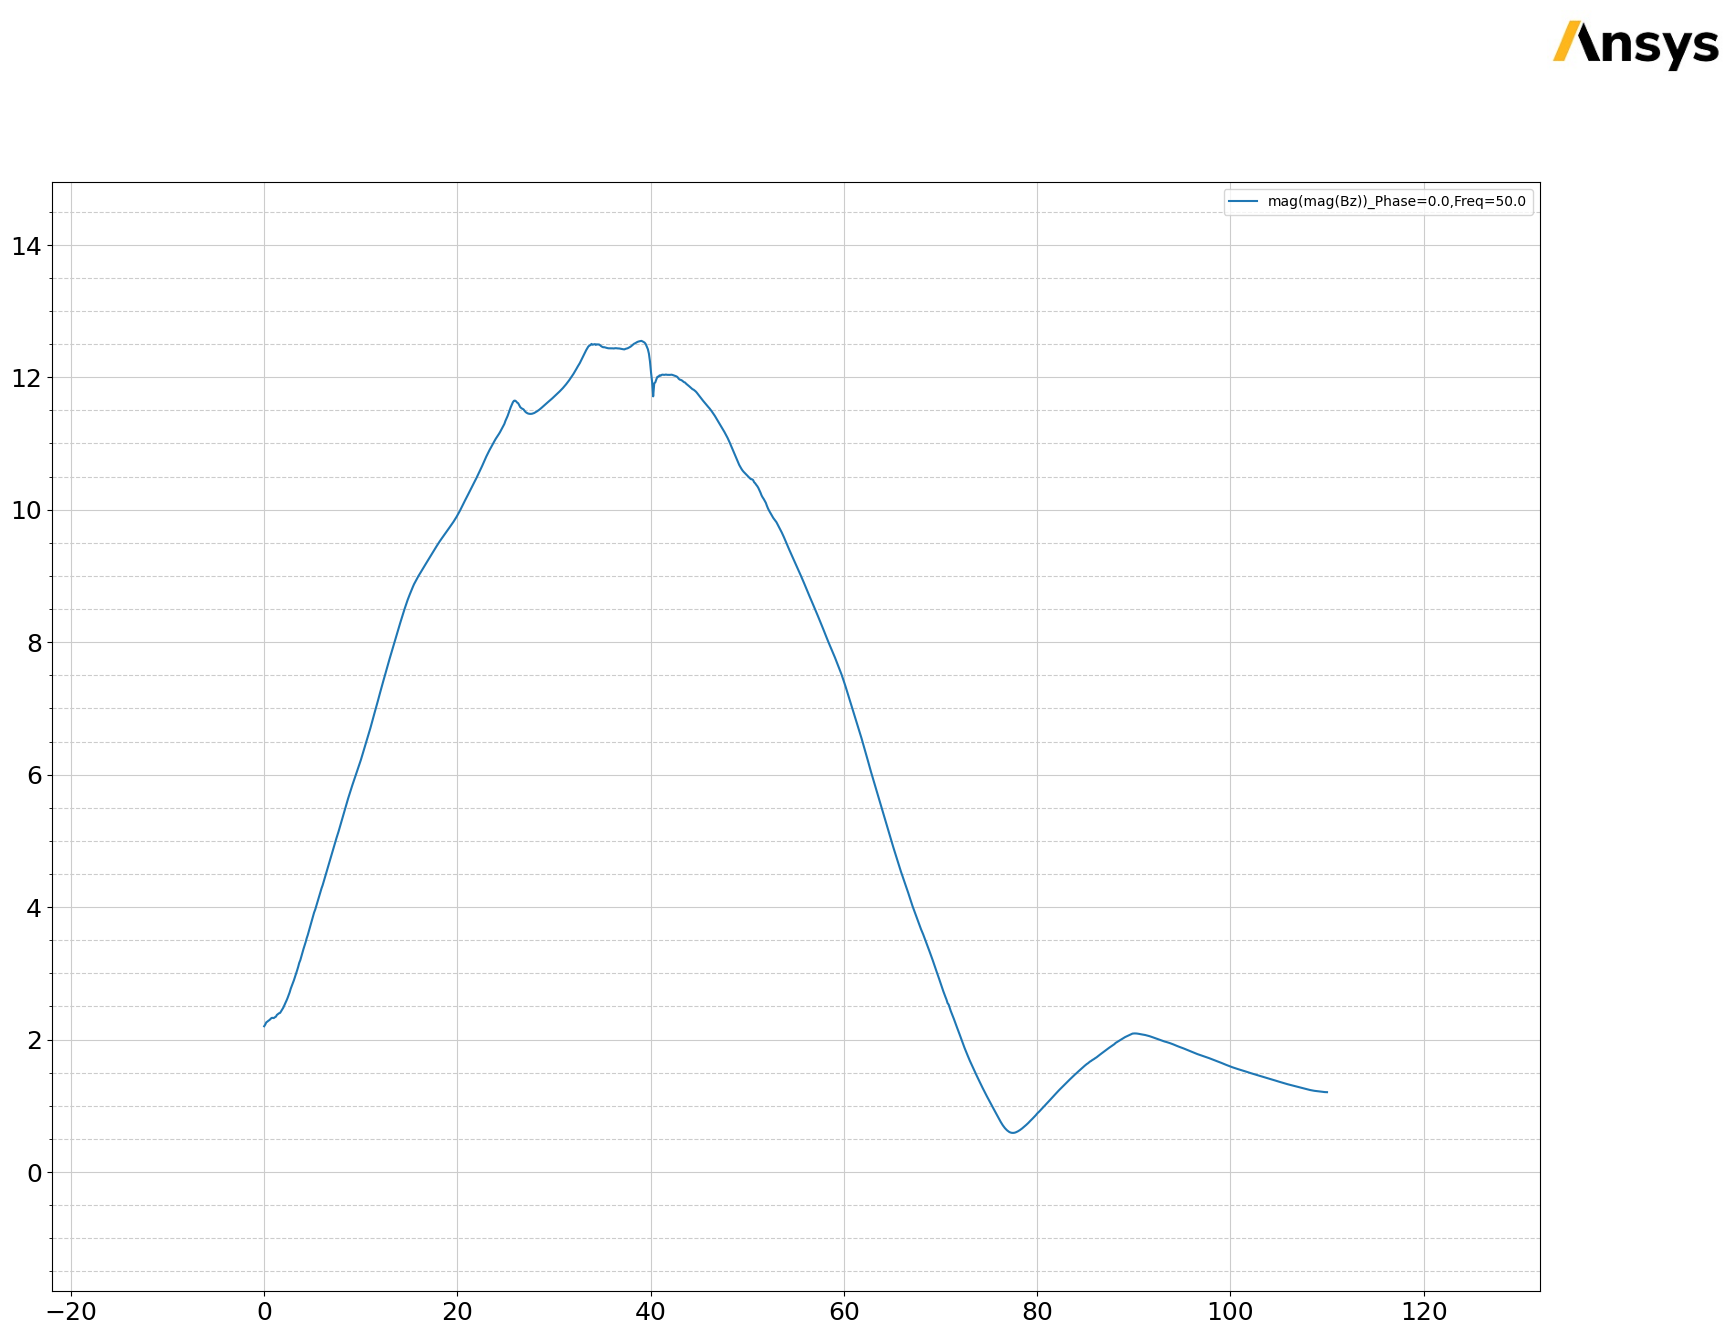

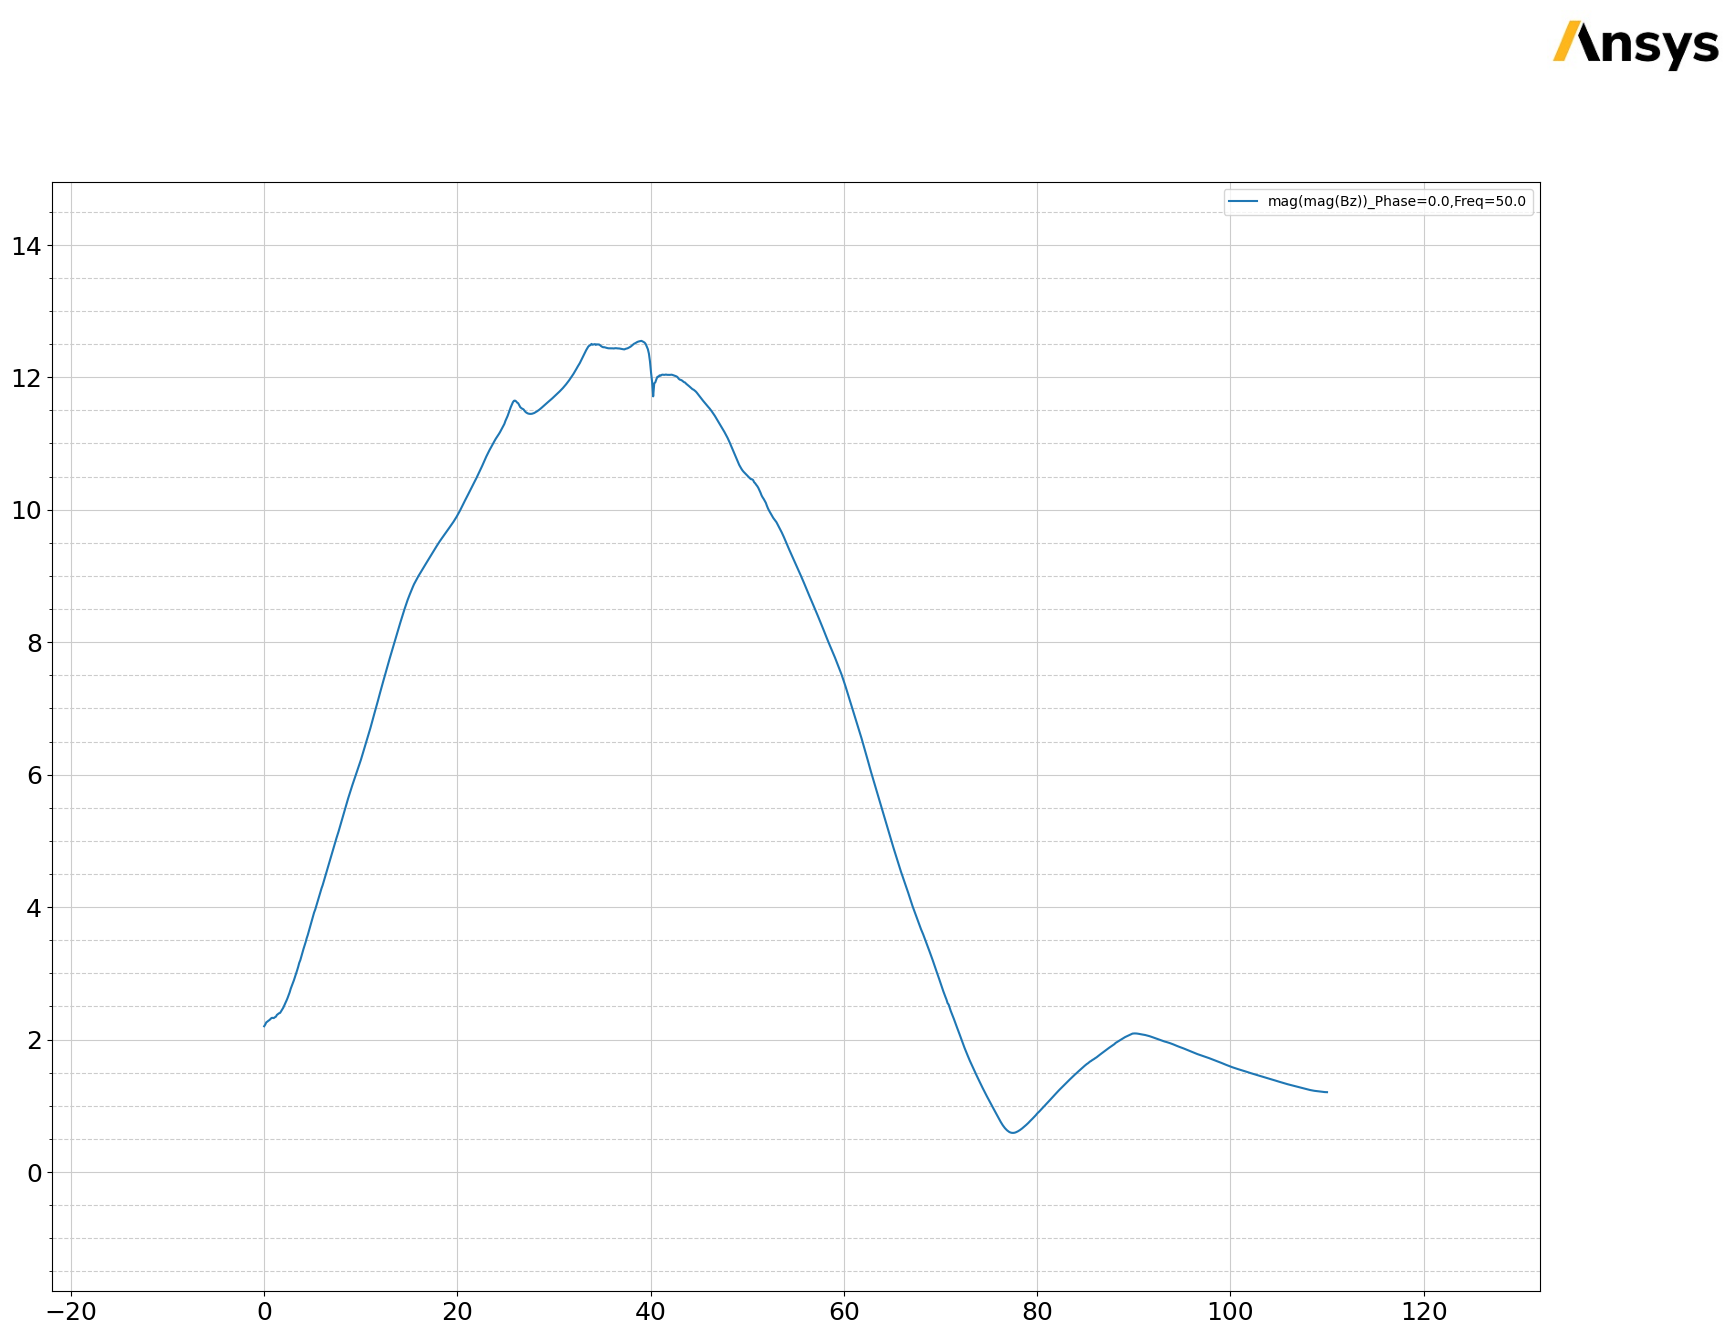

In [19]:
solutions.active_variation["Coil_Position"] = -0.02
solutions.plot()

## Change sweep value and plot solution

Change the sweep value and plot the solution again.
Uncomment to show plots.

In [20]:
solutions.active_variation["Coil_Position"] = 0
# solutions.plot()

## Plot induced current density on surface of ladder plate

Plot the induced current density, ``"Mag_J"``, on the surface of the ladder plate.

In [21]:
ladder_plate = m3d.modeler.objects_by_name["LadderPlate"]
intrinsics = {"Freq": "50Hz", "Phase": "0deg"}
m3d.post.create_fieldplot_surface(
    assignment=ladder_plate.faces,
    quantity="Mag_J",
    intrinsics=intrinsics,
    plot_name="Mag_J",
)

## Release AEDT

In [22]:
m3d.save_project()
m3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project COMPUMAG Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [23]:
temp_folder.cleanup()